# Tutorial: Gait Sequence Detection

**Author:** Masoud Abedinifar

**Last update:** Tue 01 Oct 2024

## Learning objectives
By the end of this tutorial:
- You can load data from a recording that belongs to one of the available datasets,
- Apply the Paraschiv-Ionescu gait sequence detection algorithm to accelerometer data.  
- Visualize the results of gait sequence detection.  
- Interpret the detected gait sequences for further analysis.

# Paraschiv Gait Sequence Detection

This example can be referenced by citing the package.

The example illustrates how the Paraschiv-Ionescu gait sequence detection algorithm is used to detect gait sequences using body acceleration recorded with a triaxial accelerometer worn or fixed on the lower back. The gait sequence detection algorithm is implemented using [`kielmat.modules.gsd._paraschiv`](https://github.com/neurogeriatricskiel/KielMAT/tree/main/kielmat/modules/gsd/_paraschiv.py). This algorithm is based on the research of Paraschiv-Ionescu et al [`1`-`2`].

The algorithm detects gait sequences based on identified steps. It starts by loading the accelerometer data, which includes three columns corresponding to the acceleration signals across the x, y, and z axes, along with the sampling frequency of the data. To simplify the analysis, the norm of acceleration across the x, y, and z axes is computed. Next, the signal is resampled at a 40 Hz sampling frequency using interpolation. Smoothing is then applied through a Savitzky-Golay filter and a Finite Impulse Response (FIR) low-pass filter to remove noise and drifts from the signal. The continuous wavelet transform is applied to capture gait-related features, followed by additional smoothing using successive Gaussian-weighted filters. The processed data is then analyzed to detect gait sequences.

The algorithm continues by identifying the envelope of the processed acceleration signal. Active periods of the signal are identified using the Hilbert envelope. The statistical distribution of the amplitude of the peaks in these active periods is used to derive an adaptive threshold. In case the Hilbert envelope algorithm fails to detect active periods, a fixed threshold value (0.15 g) is used for peak detection in the signal. Mid-swing peaks are detected based on this threshold. Pulse trains in the local maximum and minimum of the peaks are identified, with those having fewer than four steps filtered out. The intersection of pulse trains from local maximum and minimum peaks is detected as walking periods. These periods are then organized and grouped to update the start and end times of detected walking bouts.

Next, the algorithm takes the last steps to detect walking bouts in the signal. For this purpose, walking bouts with five or more steps are detected, and their start and end times are added to the list. Walking labels are generated as an array of zeros, and the intervals corresponding to the walking bouts are labeled as 1. Groups of consecutive zeros in the walking labels are identified, and if breaks between walking bouts are less than three seconds, they are merged. The output is then constructed as a DataFrame containing gait sequence information in BIDS format. If gait sequences are found, the output is printed; otherwise, a message indicating that no gait sequences are detected is displayed.

#### References
[`1`] Paraschiv-Ionescu et al. (2019). Locomotion and cadence detection using a single trunk-fixed accelerometer: validity for children with cerebral palsy in daily life-like conditions. Journal of NeuroEngineering and Rehabilitation, 16(1), 24. https://doi.org/10.1186/s12984-019-0494-z

[`2`] Paraschiv-Ionescu et al. (2020). Real-world speed estimation using a single trunk IMU: methodological challenges for impaired gait patterns. Annual International Conference of the IEEE Engineering in Medicine and Biology Society. IEEE Engineering in Medicine and Biology Society. https://doi.org/10.1109/EMBC44109.2020.9176281


## Import libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset, and Paraschiv-Ionescu gait sequence detection algorithms are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the 'kielmat' library and its dependencies if you haven't already.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from kielmat.datasets import mobilised
from kielmat.modules.gsd import ParaschivIonescuGaitSequenceDetection
from kielmat.config import cfg_colors

## Data Preparation

To implement the Paraschiv-Ionescu gait sequence detection algorithm, we load example data from publicly available on the Zenodo repository [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7547125.svg)](https://doi.org/10.5281/zenodo.7547125). 

The participant was assessed for 2.5 hours in the real-world while doing different daily life activities and also was asked to perform specific tasks such as outdoor walking, walking up and down a slope and stairs and moving from one room to another [`3`].

#### Refertences

.. [`3`] Mazzà, Claudia, et al. "Technical validation of real-world monitoring of gait: a multicentric observational study." BMJ open 11.12 (2021): e050785. http://dx.doi.org/10.1136/bmjopen-2021-050785


In [2]:
# Set the dataset path
dataset_path = Path(os.getcwd()) / "_mobilised"

# Fetch and load the dataset
mobilised.fetch_dataset(dataset_path=dataset_path)

# In this example, we use "SU" as tracking_system and "LowerBack" as tracked points.
tracking_sys = "SU"
tracked_points = {tracking_sys: ["LowerBack"]}

# The 'mobilised.load_recording' function is used to load the data from the specified file_path
recording = mobilised.load_recording(
    cohort="PFF",  # Choose the cohort
    file_name="data.mat", 
    dataset_path=dataset_path)

# Load lower back acceleration data
accel_data = recording.data[tracking_sys][
    ["LowerBack_ACCEL_x", "LowerBack_ACCEL_y", "LowerBack_ACCEL_z"]
]

# Get the corresponding sampling frequency directly from the recording
sampling_frequency = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "LowerBack_ACCEL_x"
]["sampling_frequency"].values[0]

#### Data Units and Conversion to SI Units

All input data provided to the modules in this toolbox should adhere to SI units to maintain consistency and accuracy across analyses. This ensures compatibility with the underlying algorithms, which are designed to work with standard metric measurements.

If any data is provided in non-SI units (e.g., acceleration in g instead of m/s²), it is needed that the data to be converted into the appropriate SI units before using it as input to the toolbox. Failure to convert non-SI units may lead to incorrect results or misinterpretation of the output.

For instance:

- **Acceleration:** Convert from g to m/s².



In [3]:
# Get the corresponding unit of the acceleration data
accel_unit = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "LowerBack_ACCEL_x"
]["units"].values[0]

# Check unit of acceleration data
if accel_unit in ["m/s^2"]:
    pass  # No conversion needed
elif accel_unit in ["g", "G"]:
    # Convert acceleration data from "g" to "m/s^2"
    accel_data *= 9.81
    # Update unit of acceleration
    accel_unit = ["m/s^2"]

## Visualisation of the Data
The raw acceleration data including components of x, y and z axis is represented.

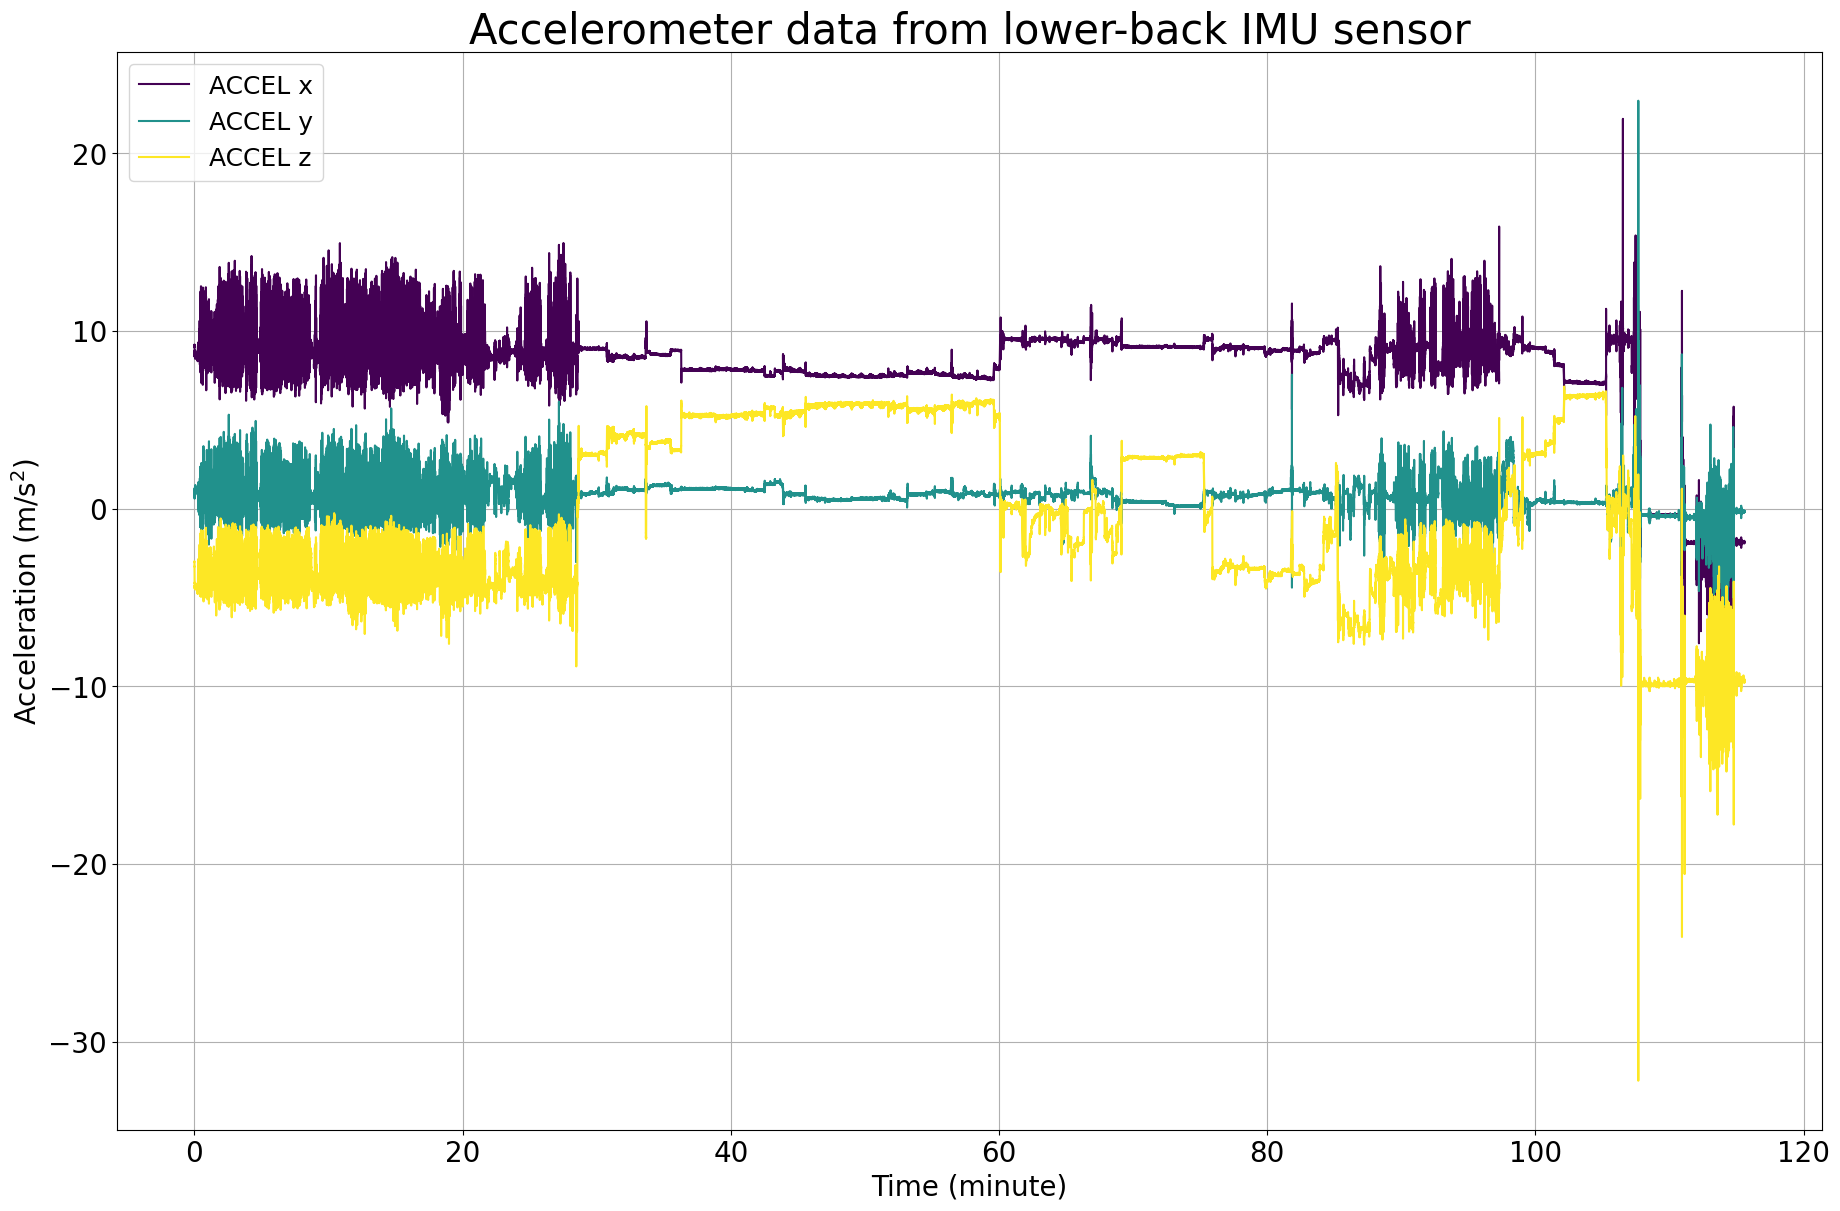

In [4]:
# Calculate the time values in minutes
# The 'time_in_minute' array represents time values in minutes, computed based on the length of 'acceleration_data' and 'sampling_frequency'.
time_in_minute = np.arange(len(accel_data)) / (60 * sampling_frequency)

# Create a figure with a specified size
plt.figure(figsize=(22, 14))

# Get colors for raw
colors = cfg_colors["raw"]

# A loop is used to plot data for each accelerometer axis, applying different colors from the color map.
for i in range(3):
    plt.plot(
        time_in_minute,
        accel_data[f"LowerBack_ACCEL_{chr(120 + i)}"],
        color=colors[i],
        label=f"ACCEL {'xyz'[i]}",
    )

# Add labels and legends
plt.xlabel("Time (minute)", fontsize=20)
plt.ylabel(f"Acceleration (m/s$^{2}$)", fontsize=20)
plt.legend(fontsize=18)

# Add a title with a specified font size
plt.title(
    "Accelerometer data from lower-back IMU sensor",
    fontsize=30,
)

# Customize tick font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()

Let's zoom in on specific time periods in the data, particularly the first 45 seconds, where clear blinks are evident.

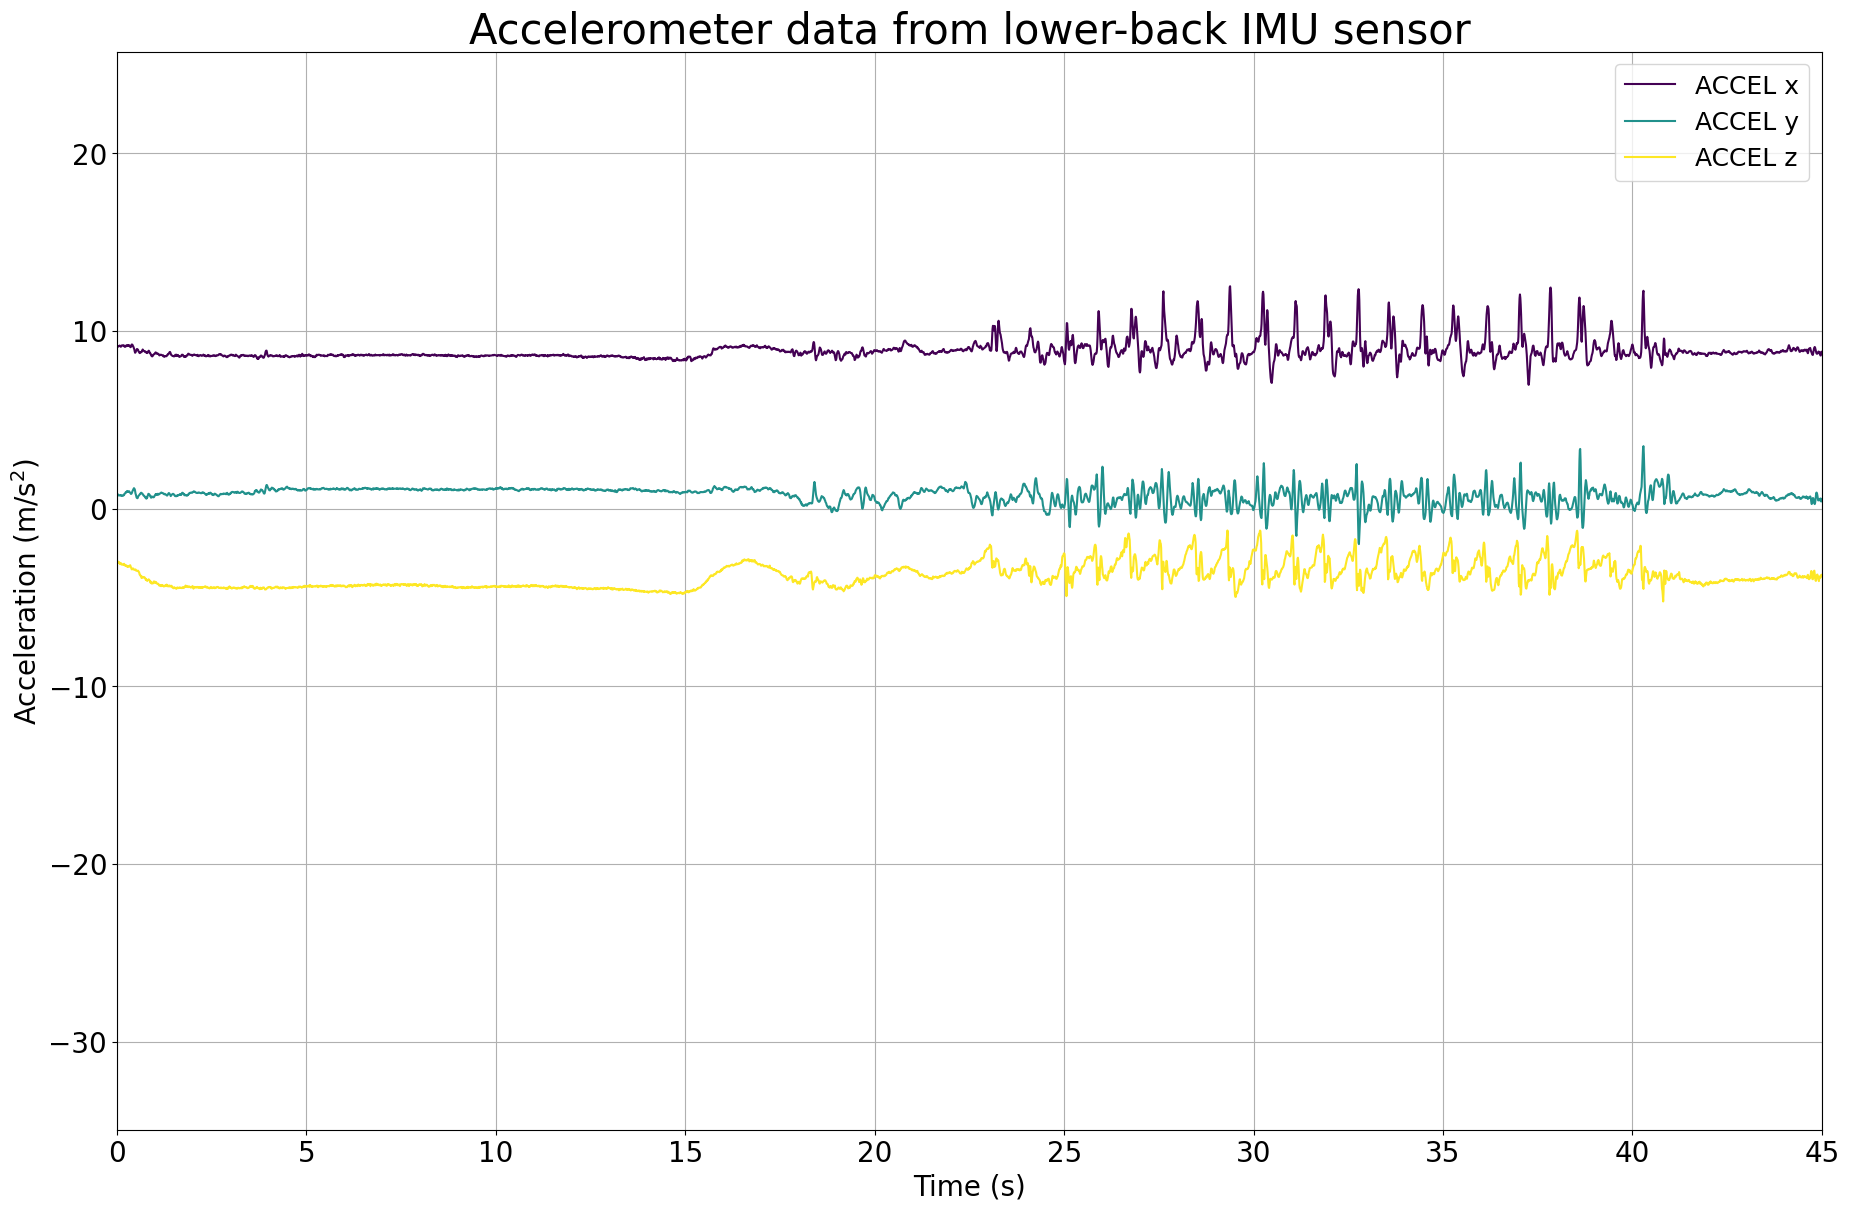

In [5]:
# Calculate the time values based on the length of the data
num_samples = len(accel_data)
time_seconds = np.arange(num_samples) / sampling_frequency

# Create a figure with the specified size
plt.figure(figsize=(22, 14))

# Plot acceleration data for each axis with time on the x-axis
for i in range(3):
    plt.plot(
        time_seconds,
        accel_data[f"LowerBack_ACCEL_{chr(120 + i)}"],
        color=colors[i],
        label=f"ACCEL {'xyz'[i]}",
    )

# Add labels and legends
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Acceleration (m/s$^{2}$)", fontsize=20)
plt.legend(fontsize=18)

# Add a title
plt.title(
    "Accelerometer data from lower-back IMU sensor",
    fontsize=30,
)

# Customize font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Set x-axis and y-axis limits for a specific duration (in seconds) and acceleration range
plt.xlim(0, 45)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()

## Applying Paraschiv-Ionescu Gait Sequence Detection Algorithm
Now, we are running Paraschiv-Ionescu gait sequence detection algorithm from gsd module [`KielMAT.kielmat.modules.gsd._paraschiv.ParaschivIonescuGaitSequenceDetection`](https://github.com/neurogeriatricskiel/KielMAT/tree/main/kielmat/modules/gsd/_paraschiv.py) to detect gait sequences.

In order to apply gait sequence detection algorithm, an instance of the ParaschivIonescuGaitSequenceDetection class is created using the constructor, `ParaschivIonescuGaitSequenceDetection()`. The `gsd` variable holds the instance, allowing us to access its methods. The inputs of the algorithm are as follows:

- **Input Data:** `accel_data` consist of accelerometer data (N, 3) for the x, y, and z axes in pandas Dataframe format. The data should be in SI unit as m/s².
- **Sampling Frequency:** `sampling_freq_Hz` is the sampling frequency of the data, defined in Hz, with a default value of 100 Hz.
- **Plot Results:** `plot_results`, if set to True, generates a plot showing the detected gait sequences on the data. The default is False. The onset is represented with the vertical green line and the grey area represents the duration of gait sequence detected by the algorithm.

36 gait sequence(s) detected.


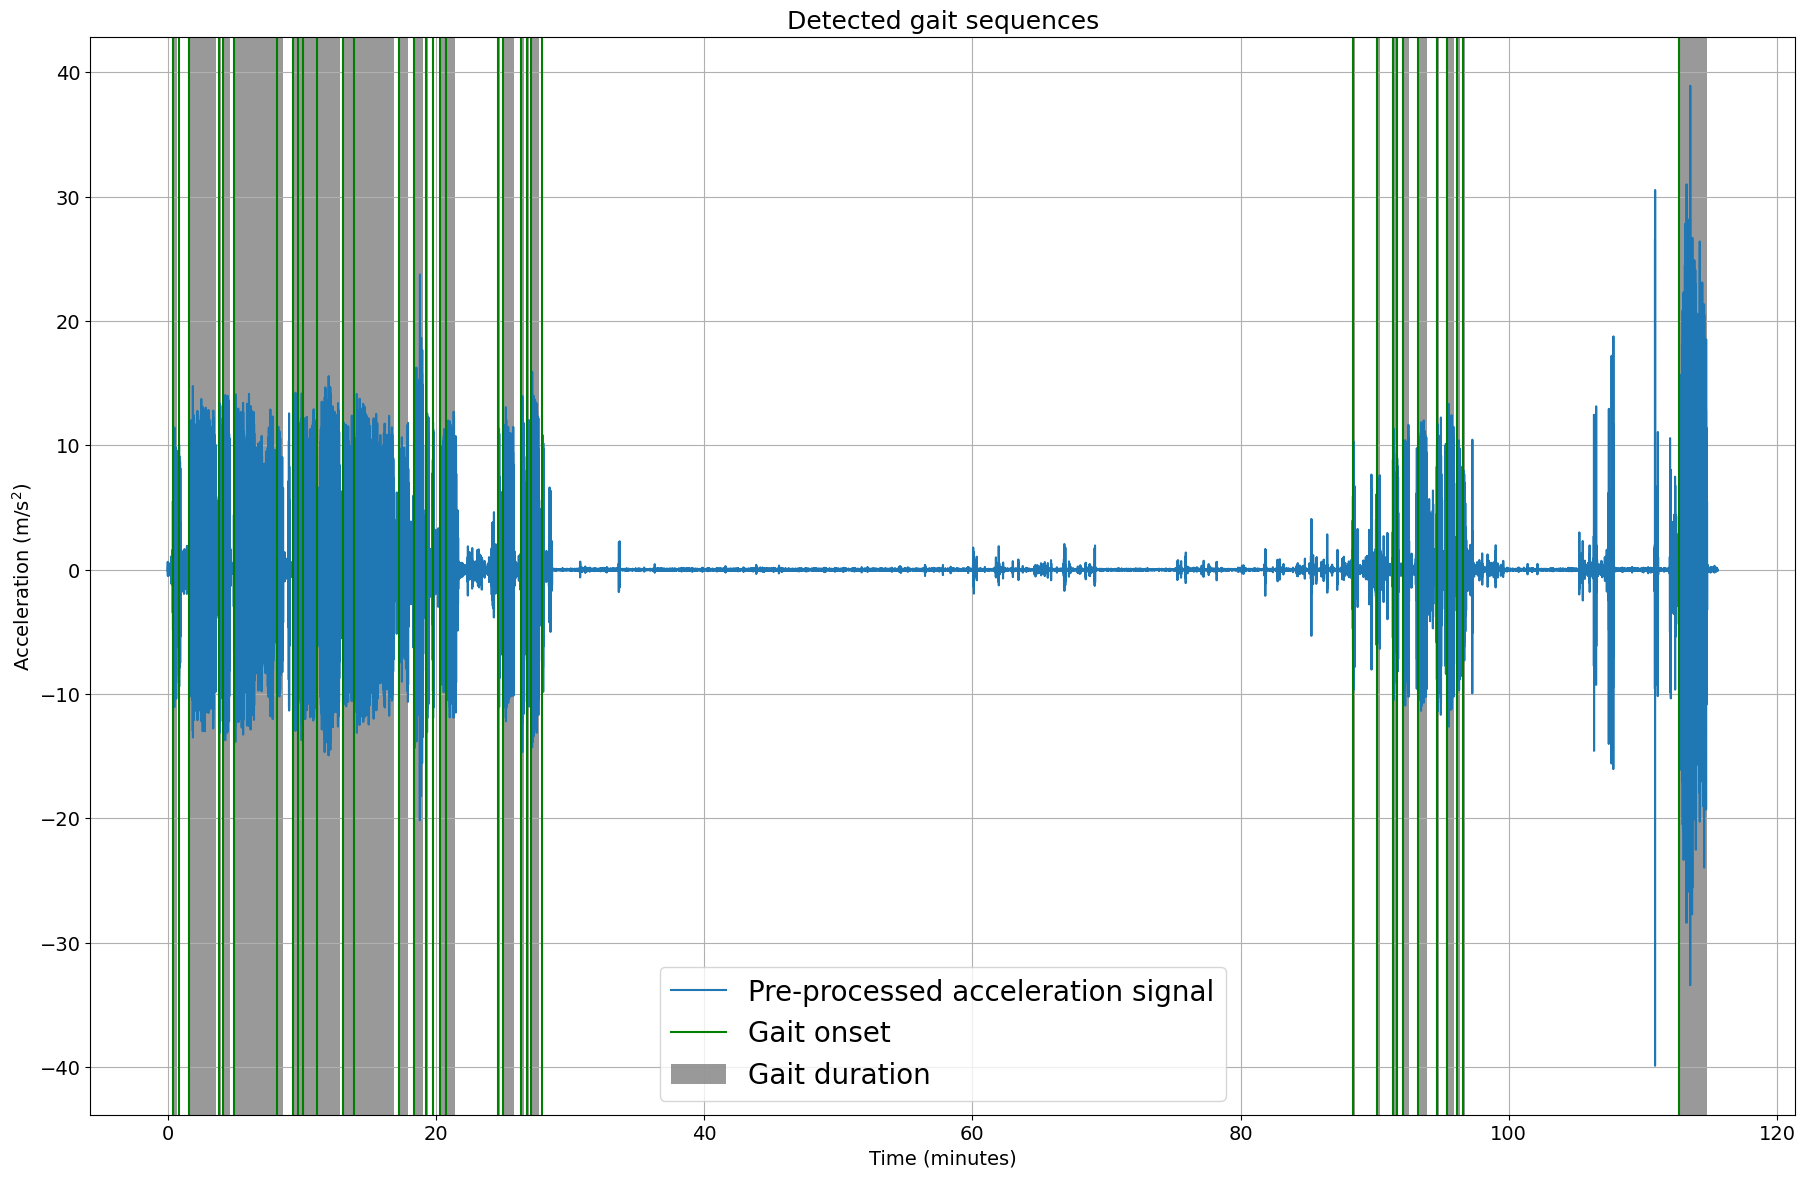

{'SU':        onset  duration     event_type tracking_system
0     22.650    17.075  gait sequence            None
1     49.150     7.475  gait sequence            None
2     97.025   120.400  gait sequence            None
3    229.550     9.225  gait sequence            None
4    247.900    29.075  gait sequence            None
5    296.225   189.600  gait sequence            None
6    490.300    25.575  gait sequence            None
7    562.925    15.075  gait sequence            None
8    581.900    18.875  gait sequence            None
9    607.050    56.600  gait sequence            None
10   667.325   101.900  gait sequence            None
11   784.500    42.775  gait sequence            None
12   835.675   174.675  gait sequence            None
13  1034.900    42.050  gait sequence            None
14  1103.075    39.475  gait sequence            None
15  1153.750    13.125  gait sequence            None
16  1184.900     5.775  gait sequence            None
17  1219.175    21.22

In [6]:
# Create an instance of the ParaschivIonescuGaitSequenceDetection class
gsd = ParaschivIonescuGaitSequenceDetection()

# Call the gait sequence detection using gsd.detect
gsd = gsd.detect(
    accel_data=accel_data, sampling_freq_Hz=sampling_frequency, plot_results=True, dt_data=None
)

# Gait sequences are stored in gait_sequences_ attribute of gsd
gait_sequences = gsd.gait_sequences_

# Add events to the recording as a dictionary including tracking system and events
gait_sequence_events = gait_sequences
recording.add_events(tracking_system=tracking_sys, new_events=gait_sequence_events)

# Show events and their corresponding information
print(recording.events)

## Detailed Visualization of the Detected Gait Sequences
In the following, the raw data of the lower back sensor is plotted with the detected events. The events are plotted as vertical lines. The events are:
- **Gait onset**: Start of the gait sequence
- **Gait duration**: Duration of the gait sequence

The onset is represented with the vertical green line and the grey area represents the duration of gait sequence detected by the algorithm.

First gait sequence:
 onset                      22.65
duration                  17.075
event_type         gait sequence
tracking_system             None
Name: 0, dtype: object


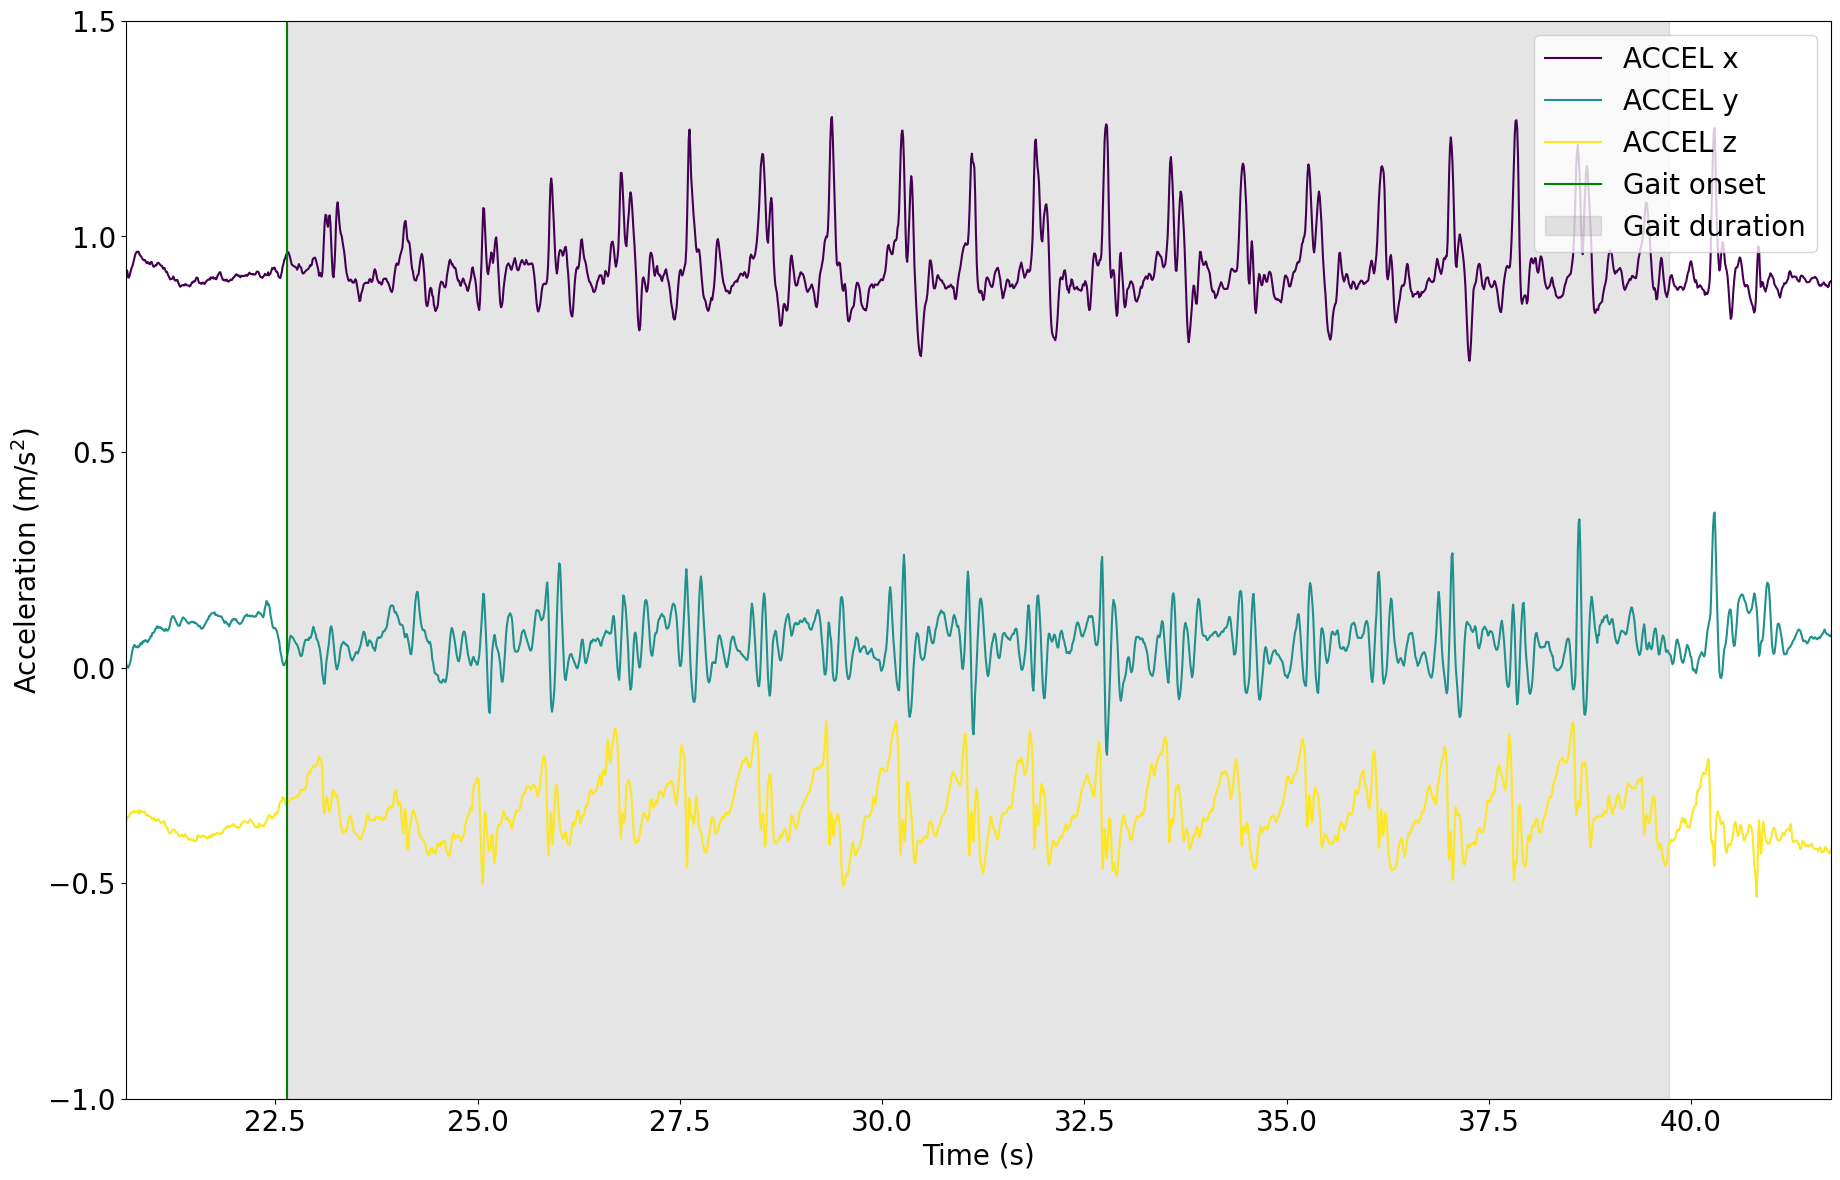

In [7]:
# Access and print first detected gait sequence
first_gait_sequence = recording.events[tracking_sys].iloc[0]
print("First gait sequence:\n", first_gait_sequence)

# Plot the raw data from the lower back
fig, ax = plt.subplots(figsize=(22, 14))

# Plot raw acceleration data
for i in range(3):
    ax.plot(
        time_seconds,
        accel_data[f"LowerBack_ACCEL_{chr(120 + i)}"],
        color=colors[i],
        label=f"ACCEL {'xyz'[i]}",
    )

# Plot the first element of gait sequences
plt.axvline(first_gait_sequence["onset"], color="g", label="Gait onset")
ax.axvspan(
    first_gait_sequence["onset"],
    first_gait_sequence["onset"] + first_gait_sequence["duration"],
    alpha=0.2,
    color="gray",
    label="Gait duration",
)

# Customize plot
start_limit = first_gait_sequence["onset"] - 2
end_limit = first_gait_sequence["onset"] + first_gait_sequence["duration"] + 2
ax.set_xlim(start_limit, end_limit)
ax.set_ylim(-1, 1.5)
ax.set_xlabel("Time (s)", fontsize=20)
ax.set_ylabel("Acceleration (m/s$^{2}$)", fontsize=20)
ax.legend(loc="upper right", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()